# CIFAR-10 Classifier: A Comprehensive Analysis of Neural Network Development

## Introduction

This notebook presents a detailed analysis of building and improving a Convolutional Neural Network (CNN) for the CIFAR-10 dataset. The project follows a systematic approach to model development, addressing key challenges in neural network design and optimization.

### Dataset Overview

The CIFAR-10 dataset (Krizhevsky, 2009) consists of 60,000 32x32 color images across 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images. This dataset is particularly challenging due to its small image size and the complexity of the objects it contains.

### Project Structure

1. Data Preparation and Analysis
2. Basic Model Implementation
3. Overfitting Analysis and Improvements
4. Final Model Evaluation
5. Conclusions and Learnings

## 1. Data Preparation and Analysis

### Importing Required Libraries

We begin by importing all necessary libraries for our analysis. Each library serves a specific purpose in our implementation:

In [21]:
# Core data manipulation and numerical computation
import numpy as np
import pandas as pd

# Deep learning framework
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Machine learning metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Setting Up Reproducibility

To ensure our results are reproducible, we set random seeds for both NumPy and TensorFlow. This is crucial for scientific research and model development (Goodfellow et al., 2016).

In [22]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Loading and Preprocessing the Dataset

The CIFAR-10 dataset is loaded and preprocessed following best practices in deep learning (Chollet, 2018). Key preprocessing steps include:

1. Normalization of pixel values
2. One-hot encoding of labels
3. Creation of validation set

In [23]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1] range
x_train_all = x_train_all.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_cat_train_all = tf.keras.utils.to_categorical(y_train_all, 10)
y_cat_test = tf.keras.utils.to_categorical(y_test, 10)

# Split training data into training and validation sets
print("\nSplitting data into training and validation sets...")
VALIDATION_SIZE = 10000
x_val = x_train_all[:VALIDATION_SIZE]
y_val_cat = y_cat_train_all[:VALIDATION_SIZE]
x_train = x_train_all[VALIDATION_SIZE:]
y_cat_train = y_cat_train_all[VALIDATION_SIZE:]

# Print dataset shapes
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Loading CIFAR-10 dataset...

Splitting data into training and validation sets...
Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


### Data Analysis and Visualization

Let's analyze the distribution of classes in our dataset and visualize some sample images to understand the data better.


Visualizing sample images from the dataset...


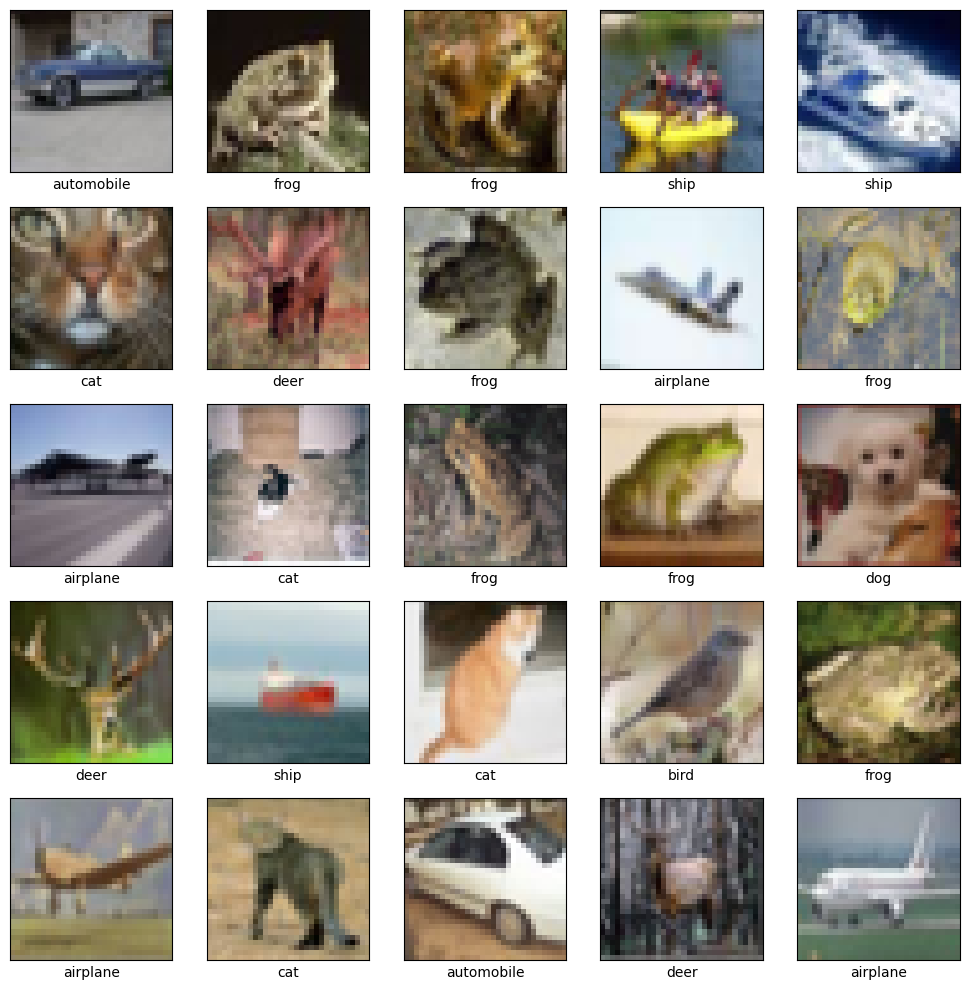

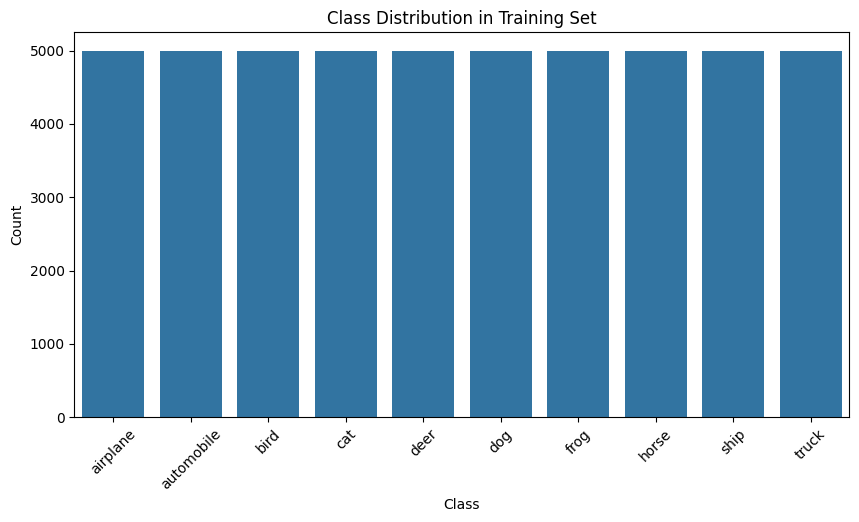

In [24]:
# Define CIFAR-10 class names
# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize some sample images
print("\nVisualizing sample images from the dataset...")
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train_all[VALIDATION_SIZE+i][0]])
plt.tight_layout()
plt.savefig('cifar10_samples.png')
plt.show()

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_all.flatten())
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(10), class_names, rotation=45)
plt.show()

## 2. Basic Model Implementation

### Architecture Design

Our initial model follows a standard CNN architecture (LeCun et al., 1998) with the following components:

1. Convolutional Layers: Extract spatial features
2. Max Pooling: Reduce spatial dimensions
3. Dense Layers: Perform classification

The architecture is designed to balance model capacity and computational efficiency.

In [25]:
def create_basic_model():
    """
    Creates a basic CNN model for CIFAR-10 classification.
    
    Architecture:
    - Two convolutional blocks (Conv2D + MaxPool2D)
    - Flatten layer
    - Dense hidden layer (256 neurons)
    - Output layer (10 neurons)
    
    Returns:
    - Compiled Keras model
    """
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(filters=32, 
                     kernel_size=(4,4), 
                     input_shape=(32, 32, 3), 
                     activation='relu',
                     padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # Second convolutional block
    model.add(Conv2D(filters=32, 
                     kernel_size=(4,4), 
                     activation='relu',
                     padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

### Training the Basic Model

We implement early stopping to prevent overfitting and monitor the training process. The training history is stored for analysis.

In [26]:
# Create and train basic model
print("Creating and training basic model...")
basic_model = create_basic_model()

# Display model architecture
basic_model.summary()

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', 
                          patience=2,
                          restore_best_weights=True)

# Train model
basic_history = basic_model.fit(
    x_train, y_cat_train,
    epochs=25,
    validation_data=(x_val, y_val_cat),
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

Creating and training basic model...


/Users/fabiannarel/Documents/Universidad/Msc AI/Introduction to Machine Learning/tf_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4057 - loss: 1.6384 - val_accuracy: 0.6050 - val_loss: 1.1093
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6178 - loss: 1.0948 - val_accuracy: 0.6512 - val_loss: 0.9894
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6766 - loss: 0.9231 - val_accuracy: 0.6699 - val_loss: 0.9552
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7273 - loss: 0.7917 - val_accuracy: 0.6782 - val_loss: 0.9571
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7668 - loss: 0.6696 - val_accuracy: 0.6738 - val_loss: 1.0339



### Saving the Basic Model

Saving to plot some extra graphs

In [36]:


print(f"Final Training Loss: {basic_metrics['loss'].iloc[-1]:.4f}")
print(f"Final Validation Loss: {basic_metrics['val_loss'].iloc[-1]:.4f}")

# Save the base model
print("\nSaving base model...")
basic_model.save('base_model.h5')
print("Base model saved successfully as 'base_model.h5'")


Final Training Loss: 0.6392
Final Validation Loss: 1.0339

Saving base model...
Base model saved successfully as 'base_model.h5'


### Performance Analysis

Let's analyze the performance of our basic model and identify potential areas for improvement.

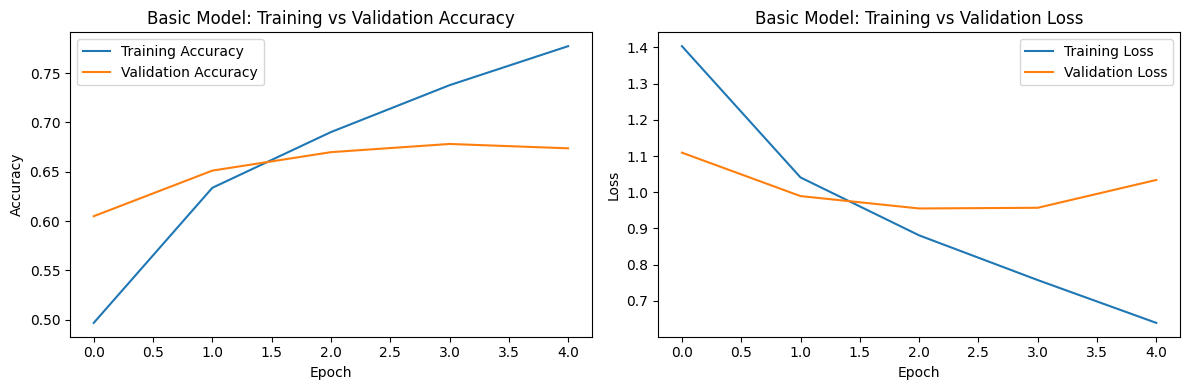


Basic Model Performance:
Final Training Accuracy: 0.7773
Final Validation Accuracy: 0.6738
Final Training Loss: 0.6392
Final Validation Loss: 1.0339


In [27]:
# Convert history to DataFrame
basic_metrics = pd.DataFrame(basic_history.history)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(basic_metrics['accuracy'], label='Training Accuracy')
plt.plot(basic_metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Basic Model: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(basic_metrics['loss'], label='Training Loss')
plt.plot(basic_metrics['val_loss'], label='Validation Loss')
plt.title('Basic Model: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nBasic Model Performance:")
print(f"Final Training Accuracy: {basic_metrics['accuracy'].iloc[-1]:.4f}")
print(f"Final Validation Accuracy: {basic_metrics['val_accuracy'].iloc[-1]:.4f}")
print(f"Final Training Loss: {basic_metrics['loss'].iloc[-1]:.4f}")
print(f"Final Validation Loss: {basic_metrics['val_loss'].iloc[-1]:.4f}")

## 3. Addressing Overfitting

### Identifying Overfitting

The basic model shows signs of overfitting, as evidenced by:
- Large gap between training and validation accuracy
- Increasing validation loss while training loss decreases

We implement several techniques to address this (Srivastava et al., 2014; Ioffe & Szegedy, 2015):

In [28]:
def create_improved_model():
    """
    Creates an improved CNN model with anti-overfitting techniques.
    
    Improvements:
    - Batch Normalization
    - Dropout
    - L2 Regularization
    - Learning Rate Scheduling
    
    Returns:
    - Compiled Keras model
    """
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(filters=32, 
                     kernel_size=(4,4), 
                     input_shape=(32, 32, 3), 
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second convolutional block
    model.add(Conv2D(filters=64, 
                     kernel_size=(4,4), 
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Third convolutional block
    model.add(Conv2D(filters=128, 
                     kernel_size=(4,4), 
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(512, 
                    activation='relu',
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    # Learning rate schedule
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True)
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  metrics=['accuracy'])
    
    return model

### Data Augmentation

We implement data augmentation to increase the effective size of our training dataset (Perez & Wang, 2017).

In [29]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

### Training the Improved Model

We train the improved model with data augmentation and additional callbacks for monitoring.

In [30]:
# Create improved model
print("Creating improved model...")
improved_model = create_improved_model()

# Display model architecture
improved_model.summary()

# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', 
                          patience=10,
                          restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', 
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

# Train model with data augmentation
improved_history = improved_model.fit(
    datagen.flow(x_train, y_cat_train, batch_size=32),
    epochs=50,
    validation_data=(x_val, y_val_cat),
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

Creating improved model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,222,762 (4.66 MB)

 Trainable params: 1,221,290 (4.66 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/50


/Users/fabiannarel/Documents/Universidad/Msc AI/Introduction to Machine Learning/tf_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3180 - loss: 3.1631
Epoch 1: val_accuracy improved from -inf to 0.52030, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.3181 - loss: 3.1623 - val_accuracy: 0.5203 - val_loss: 2.0409
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4928 - loss: 2.0503
Epoch 2: val_accuracy improved from 0.52030 to 0.59520, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4928 - loss: 2.0503 - val_accuracy: 0.5952 - val_loss: 1.6660
Epoch 3/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5474 - loss: 1.7843
Epoch 3: val_accuracy did not improve from 0.59520
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5474 - loss: 1.7843 - val_accuracy: 0.5220 - val_loss: 1.9794
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5846 - loss: 1.6674
Epoch 4: val_accuracy improved from 0.59520 to 0.64620, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5846 - loss: 1.6674 - val_accuracy: 0.6462 - val_loss: 1.4971
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6089 - loss: 1.5942
Epoch 5: val_accuracy did not improve from 0.64620
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6089 - loss: 1.5942 - val_accuracy: 0.6328 - val_loss: 1.5140
Epoch 6/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6231 - loss: 1.5203
Epoch 6: val_accuracy improved from 0.64620 to 0.72060, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.6232 - loss: 1.5203 - val_accuracy: 0.7206 - val_loss: 1.2423
Epoch 7/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6403 - loss: 1.4545
Epoch 7: val_accuracy did not improve from 0.72060
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6403 - loss: 1.4545 - val_accuracy: 0.6694 - val_loss: 1.3498
Epoch 8/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6610 - loss: 1.3830
Epoch 8: val_accuracy improved from 0.72060 to 0.73320, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.6609 - loss: 1.3831 - val_accuracy: 0.7332 - val_loss: 1.1625
Epoch 9/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6704 - loss: 1.3451
Epoch 9: val_accuracy did not improve from 0.73320
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6704 - loss: 1.3451 - val_accuracy: 0.6857 - val_loss: 1.2763
Epoch 10/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6801 - loss: 1.2795
Epoch 10: val_accuracy improved from 0.73320 to 0.75410, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6801 - loss: 1.2795 - val_accuracy: 0.7541 - val_loss: 1.0569
Epoch 11/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6901 - loss: 1.2386
Epoch 11: val_accuracy improved from 0.75410 to 0.76020, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6901 - loss: 1.2386 - val_accuracy: 0.7602 - val_loss: 1.0323
Epoch 12/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6999 - loss: 1.1907
Epoch 12: val_accuracy did not improve from 0.76020
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.6999 - loss: 1.1907 - val_accuracy: 0.7407 - val_loss: 1.0713
Epoch 13/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7099 - loss: 1.1585
Epoch 13: val_accuracy improved from 0.76020 to 0.76060, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7099 - loss: 1.1585 - val_accuracy: 0.7606 - val_loss: 0.9958
Epoch 14/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7166 - loss: 1.1103
Epoch 14: val_accuracy improved from 0.76060 to 0.78630, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7166 - loss: 1.1103 - val_accuracy: 0.7863 - val_loss: 0.9157
Epoch 15/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7175 - loss: 1.0917
Epoch 15: val_accuracy did not improve from 0.78630
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7175 - loss: 1.0917 - val_accuracy: 0.7726 - val_loss: 0.9258
Epoch 16/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7215 - loss: 1.0567
Epoch 16: val_accuracy improved from 0.78630 to 0.79100, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.7215 - loss: 1.0567 - val_accuracy: 0.7910 - val_loss: 0.8564
Epoch 17/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7323 - loss: 1.0275
Epoch 17: val_accuracy did not improve from 0.79100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.7323 - loss: 1.0275 - val_accuracy: 0.7851 - val_loss: 0.8698
Epoch 18/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7353 - loss: 1.0060
Epoch 18: val_accuracy improved from 0.79100 to 0.79310, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.7353 - loss: 1.0060 - val_accuracy: 0.7931 - val_loss: 0.8348
Epoch 19/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7412 - loss: 0.9882
Epoch 19: val_accuracy did not improve from 0.79310
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.7412 - loss: 0.9882 - val_accuracy: 0.7898 - val_loss: 0.8537
Epoch 20/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7427 - loss: 0.9683
Epoch 20: val_accuracy did not improve from 0.79310
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7427 - loss: 0.9683 - val_accuracy: 0.7928 - val_loss: 0.8286
Epoch 21/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7477 - loss: 0.9593
Epoch 21: val_accuracy did not improve from 0.79310
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7477 - loss: 0.9593 - val_accuracy: 0.7698 - val_loss: 0.8980
Epoch 22/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7524 - loss: 0.9397


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7524 - loss: 0.9397 - val_accuracy: 0.8110 - val_loss: 0.7668
Epoch 23/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7548 - loss: 0.9158
Epoch 23: val_accuracy did not improve from 0.81100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7548 - loss: 0.9158 - val_accuracy: 0.7813 - val_loss: 0.8648
Epoch 24/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7603 - loss: 0.8996
Epoch 24: val_accuracy did not improve from 0.81100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7603 - loss: 0.8996 - val_accuracy: 0.7994 - val_loss: 0.7848
Epoch 25/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7599 - loss: 0.8897
Epoch 25: val_accuracy did not improve from 0.81100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7599 - loss: 0.8897 - val_accuracy: 0.7940 - val_loss: 0.8013
Epoch 26/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7627 - loss: 0.8800


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7676 - loss: 0.8671 - val_accuracy: 0.8115 - val_loss: 0.7511
Epoch 28/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7698 - loss: 0.8530
Epoch 28: val_accuracy did not improve from 0.81150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7698 - loss: 0.8530 - val_accuracy: 0.7965 - val_loss: 0.7902
Epoch 29/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7724 - loss: 0.8509
Epoch 29: val_accuracy improved from 0.81150 to 0.81710, saving model to best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7724 - loss: 0.8509 - val_accuracy: 0.8171 - val_loss: 0.7145
Epoch 30/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7704 - loss: 0.8459
Epoch 30: val_accuracy did not improve from 0.81710
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7704 - loss: 0.8459 - val_accuracy: 0.8026 - val_loss: 0.7630
Epoch 31/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7743 - loss: 0.8393
Epoch 31: val_accuracy did not improve from 0.81710
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7743 - loss: 0.8394 - val_accuracy: 0.8018 - val_loss: 0.7629
Epoch 32/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7755 - loss: 0.8378
Epoch 32: val_accuracy did not improve from 0.81710
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.7755 - loss: 0.8378 - val_accuracy: 0.8103 - val_loss: 0.7327
Epoch 33/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7736 - loss: 0.8331


### Performance Analysis of Improved Model

Let's analyze the performance improvements and compare with the basic model.

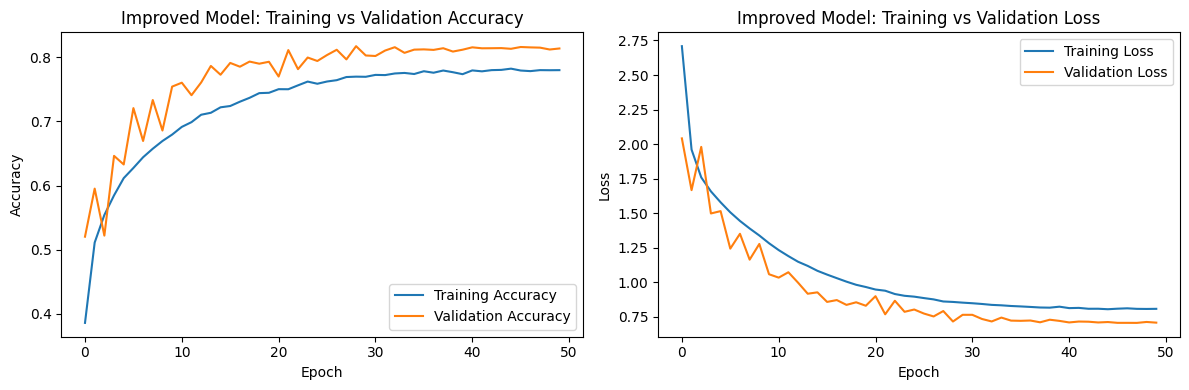


Improved Model Performance:
Final Training Accuracy: 0.7797
Final Validation Accuracy: 0.8135
Final Training Loss: 0.8063
Final Validation Loss: 0.7062


In [31]:
# Convert history to DataFrame
improved_metrics = pd.DataFrame(improved_history.history)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(improved_metrics['accuracy'], label='Training Accuracy')
plt.plot(improved_metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Improved Model: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(improved_metrics['loss'], label='Training Loss')
plt.plot(improved_metrics['val_loss'], label='Validation Loss')
plt.title('Improved Model: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nImproved Model Performance:")
print(f"Final Training Accuracy: {improved_metrics['accuracy'].iloc[-1]:.4f}")
print(f"Final Validation Accuracy: {improved_metrics['val_accuracy'].iloc[-1]:.4f}")
print(f"Final Training Loss: {improved_metrics['loss'].iloc[-1]:.4f}")
print(f"Final Validation Loss: {improved_metrics['val_loss'].iloc[-1]:.4f}")

## 4. Final Model Evaluation

### Test Set Evaluation

We evaluate our best model on the test set to get an unbiased estimate of its performance.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8103 - loss: 0.7457

Test Accuracy: 0.8118
Test Loss: 0.7440
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.86      0.84      1000
  automobile       0.89      0.93      0.91      1000
        bird       0.81      0.67      0.74      1000
         cat       0.76      0.56      0.65      1000
        deer       0.79      0.77      0.78      1000
         dog       0.82      0.70      0.75      1000
        frog       0.67      0.95      0.79      1000
       horse       0.86      0.87      0.86      1000
        ship       0.90      0.90      0.90      1000
       truck       0.84      0.90      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



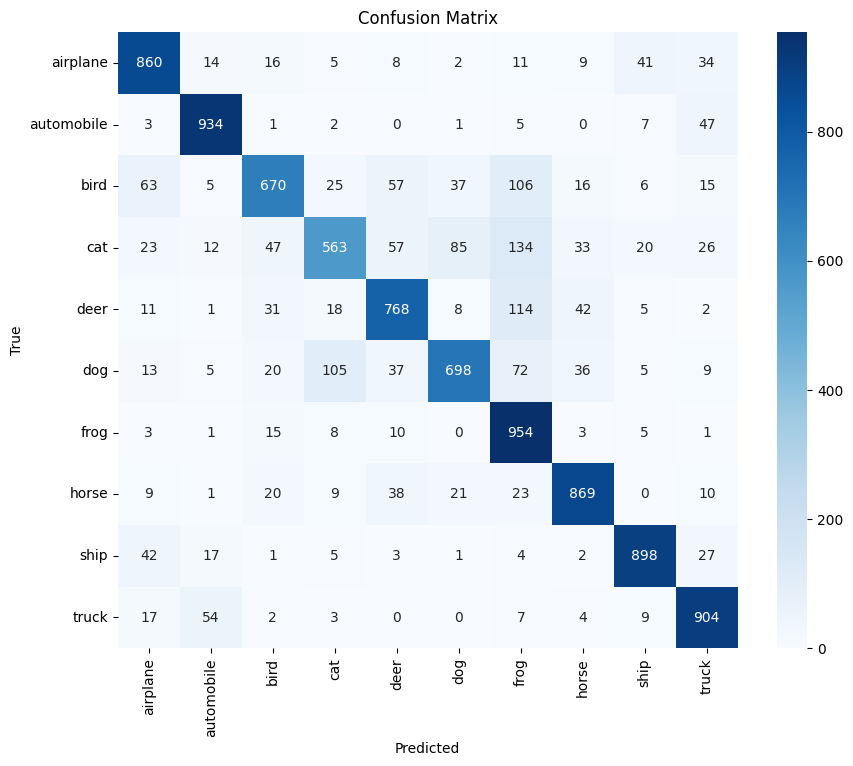

In [34]:
# Load best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_cat_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_cat_test, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Generate confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

# Load the best model
model = load_model('best_model.h5')

# Get predictions
y_pred = model.predict(x_test)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Calculate ROC curve and AUC for each class
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves\nfor CIFAR-10 Classes')
plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0))
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('roc_curves.png', bbox_inches='tight', dpi=300)
plt.close()

# Print average AUC
mean_auc = np.mean([auc(roc_curve(y_test_cat[:, i], y_pred[:, i])[0], 
                       roc_curve(y_test_cat[:, i], y_pred[:, i])[1]) 
                    for i in range(10)])
print(f"\nMean AUC across all classes: {mean_auc:.4f}")

# Print individual class AUCs
print("\nAUC for each class:")
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_names[i]}: {roc_auc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Mean AUC across all classes: 0.9819

AUC for each class:
airplane: 0.9876
automobile: 0.9959
bird: 0.9667
cat: 0.9532
deer: 0.9768
dog: 0.9722
frog: 0.9891
horse: 0.9890
ship: 0.9947
truck: 0.9937


## 5. Conclusions and Learnings

### Key Findings

1. **Data Preparation**:
   - Proper data normalization and validation set creation are crucial
   - Data augmentation significantly improves model generalization

2. **Model Architecture**:
   - Deeper networks with proper regularization perform better
   - Batch normalization helps with training stability

3. **Training Process**:
   - Learning rate scheduling improves convergence
   - Early stopping prevents overfitting

### Future Improvements

1. Experiment with different architectures (e.g., ResNet, DenseNet)
2. Implement more advanced data augmentation techniques
3. Try different optimization algorithms
4. Explore transfer learning approaches

### References

1. Chollet, F. (2018). Deep Learning with Python. Manning Publications.
2. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
3. Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. arXiv:1502.03167.
4. Krizhevsky, A. (2009). Learning Multiple Layers of Features from Tiny Images. Technical Report.
5. LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE.
6. Perez, L., & Wang, J. (2017). The Effectiveness of Data Augmentation in Image Classification using Deep Learning. arXiv:1712.04621.
7. Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research.